In [1]:
if 'google.colab' in str(get_ipython()):
    !pip uninstall tensorflow -y
    !pip install tensorflow==2.3.1 tensorflow-quantum neptune-client
    !rm -rf quantum-gans
    !git clone https://github.com/WiktorJ/quantum-gans
    !cd quantum-gans; pip install .
    neptun_token = "" # put manually for the time being
else:
    import subprocess
    def get_var(varname):
        CMD = 'echo $(source ~/.bash_profile; echo $%s)' % varname
        p = subprocess.Popen(CMD, stdout=subprocess.PIPE, shell=True, executable='/bin/bash')
        return p.stdout.readlines()[0].strip()
    neptun_token = get_var('NEPTUNE_API_TOKEN').decode("utf-8") 

In [4]:
%load_ext autoreload
%autoreload 2

In [25]:
import neptune
import tensorflow as tf

import cirq
import numpy as np
from qsgenerator import circuits
from qsgenerator.quwgans import circuits as quwgans_circuits
from qsgenerator.quwgans.training import Trainer
from qsgenerator.phase.circuits import PhaseCircuitBuilder
from qsgenerator.evaluators.circuit_evaluator import CircuitEvaluator
from qsgenerator.phase.analitical import get_theta_v, get_theta_w, get_theta_r, get_g_parameters_provider


In [16]:
use_neptune = False

In [408]:
generator_layers = 2
data_bus_size = 4
generator_bath_size = 1

In [409]:
real_phase = True
generic_generator = True
zxz = False
all_gates_parametrized = False

In [410]:
data_qubits = qubits = cirq.GridQubit.rect(1, data_bus_size)

In [411]:
builder = PhaseCircuitBuilder(all_gates_parametrized=False)
real, real_symbols, symbols_dict_real = builder.build_ground_state_circuit(qubits=data_qubits)

In [412]:
pauli_strings, qubit_to_string_index = quwgans_circuits.get_discriminator(real)

In [413]:
if generic_generator:
    gen, gs = circuits.build_circuit(generator_layers, data_qubits, "g")
    symbols_dict_gen = {}
else:
    builder = PhaseCircuitBuilder(all_gates_parametrized=all_gates_parametrized)
    gen, gs, symbols_dict_gen = builder.build_ground_state_circuit(qubits=data_qubits, full_parametrization=True, zxz=zxz)

In [414]:
print("REAL GROUND STATE")
real

REAL GROUND STATE


(0, 0): ───H───@─────────────────────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               │                         │
(0, 1): ───────X───Z───Ry(theta_r)───H───X───H───X─────────────@───X───────────────────────────────────@───X─────────────────────────────────────────────────────────────────────────────────────────────────────
                                                               │                                       │
(0, 2): ─────────────────────────────────────────Ry(theta_w)───X───X───Ry(theta_w)───X───Ry(theta_v)───X───X───Ry(theta_v)───X───X─────────────@───X───────────────────────────────────@───X─────────────────────
                                                                                                                                               │                                       │
(0, 3): ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta_w)───X───X───Ry(theta_w)───X───Ry(theta_v)───X───X───Ry(theta_v)───X───

In [415]:
print("GENERATOR")
gen

GENERATOR


(0, 0): ───Rx(g0)───Rz(g4)───ZZ───────────────Rx(g11)───Rz(g15)───ZZ────────────────
                             │                                    │
(0, 1): ───Rx(g1)───Rz(g5)───ZZ^g8───ZZ───────Rx(g12)───Rz(g16)───ZZ^g19───ZZ───────
                                     │                                     │
(0, 2): ───Rx(g2)───Rz(g6)───ZZ──────ZZ^g10───Rx(g13)───Rz(g17)───ZZ───────ZZ^g21───
                             │                                    │
(0, 3): ───Rx(g3)───Rz(g7)───ZZ^g9────────────Rx(g14)───Rz(g18)───ZZ^g20────────────

In [416]:
g_values = [-0.5]
real_values_provider = get_g_parameters_provider()

In [417]:
opt = tf.keras.optimizers.Adam(0.01, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [418]:
trainer = Trainer(real, 
                  real_symbols,
                  gen,
                  gs,
                  g_values,
                  real_values_provider,
                  use_neptune=use_neptune)

In [419]:
epochs = 1000
gen_iteration = 1
snapshot_interval_epochs = 100

<Figure size 432x288 with 0 Axes>

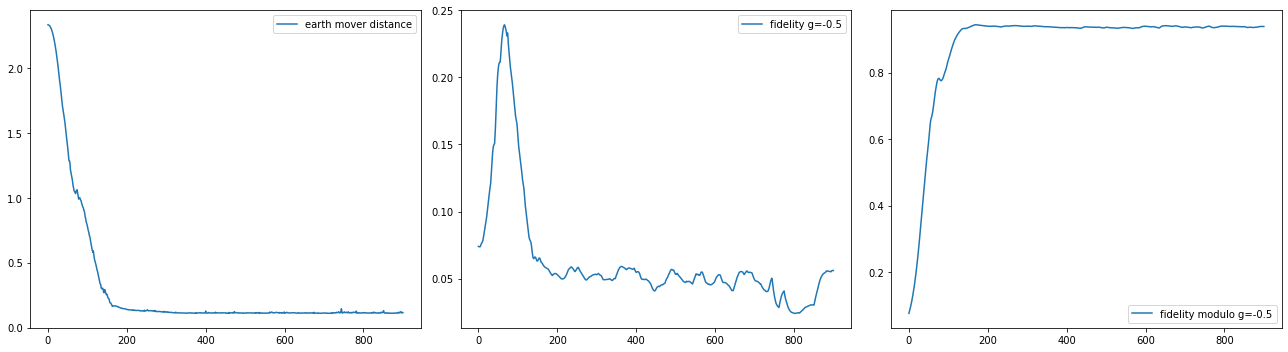

----------------------------------------------------
Epoch 900:  distance = 0.11486505633524483
h=Z((0, 2)), w=0.9999999929722082, e=0.00521378219127655
h=Z((0, 1))*Z((0, 3)), w=0.9999999927177784, e=0.10965127497911453
Fidelity for g=-0.5 : 0.056016463595676136
Fidelity modulo for g=-0.5 : 0.056016463595676136


In [420]:
trainer.train(opt, epochs, gen_iteration, snapshot_interval_epochs, plot=True)

In [368]:
def get_states_and_fidelty_for_real(gen_evaluator, 
                                    real_evaluator,
                                    g, 
                                    size):
    generated = gen_evaluator.get_state_from_params(trace_dims=list(range(size)))
    real = real_evaluator.get_state_from_params(g)
    return generated, real, cirq.fidelity(generated, real), cirq.fidelity(abs(generated), abs(real))

In [369]:
gen_evaluator = trainer.gen_evaluator
real_evaluator = trainer.real_evaluator

In [362]:
gen_evaluator.circuit.append([cirq.H(data_qubits[0])])

In [363]:
gen_evaluator.circuit

(0, 0): ───Rx(g0)───Rz(g3)───ZZ──────────────Rx(g8)────Rz(g11)───ZZ───────X────────X───H───H───
                             │                                   │
(0, 1): ───Rx(g1)───Rz(g4)───ZZ^g6───ZZ──────Rx(g9)────Rz(g12)───ZZ^g14───ZZ───────────────────
                                     │                                    │
(0, 2): ───Rx(g2)───Rz(g5)───────────ZZ^g7───Rx(g10)───Rz(g13)────────────ZZ^g15───────────────

In [372]:
g = g_values[0]
generated_state, real_state, fidelity, abs_fidelity = get_states_and_fidelty_for_real(gen_evaluator, real_evaluator, g, data_bus_size)

In [373]:
generated_state, real_state, fidelity, abs_fidelity

(array([-0.2154793 -0.2515042j , -0.30712613-0.35557985j,
         0.21746853+0.25720018j, -0.15528816-0.1770467j ,
        -0.17139682-0.16038331j, -0.24480163-0.22601509j,
         0.34456605+0.32536352j, -0.24459085-0.22388345j], dtype=complex64),
 array([ 0.3333333 +0.j,  0.47140452+0.j,  0.33333334+0.j, -0.23570225+0.j,
         0.23570225+0.j,  0.33333337+0.j,  0.47140452+0.j, -0.3333333 +0.j],
       dtype=complex64),
 0.00029199470587562906,
 0.9999701978996569)

In [367]:
 cirq.fidelity(abs(generated_state), abs(real_state))

0.9999701978996569